<a href="https://colab.research.google.com/github/ge6fit1995/pytorchviz/blob/master/CoinDetection_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2のセットアップ

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 9.0MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=9802d212869e0a9bdb50aad7071989cdc245152ae2dac21471d1a1e37b0e8f84
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 6.5MB/s 
     |████████████████████████████████| 2.2MB 14.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210204-cp36-none-any.whl size=44945 sha256=aba4753efcdbe1cde6679c60342fb37015417018f1bc1a8d0e7051e10d586750
  Stored in directory: /root/.cache/pip/wheels/7a/d5/3d/1393f94e0a0c6345f674387da5bd382c9aba98a23371a3804e
  Created wheel for iopath: filename=iopath-0.1.3-cp36-none-any.whl size=11169 sha256=5da24bea4722522e66dd715f53fb016e3105d14762e8474b0f106bbdc3aa85c3
  Stored in directory: /root/.cache/pip/wheels/a9/1d/55/94a55e032409ac7617f9cbb88a0fa2cf4e7208806c29730804
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# データセット登録

硬貨の画像データセットを用意しました．各画像には1~4枚程度の硬貨（1円玉，5円玉，10円玉，100円玉の４種類，重複あり）が含まれています．`coco-1612779490.2197058.json`には各画像のAnnotation（硬貨の位置と種類）がCOCOフォーマットで入っています．ただし`IMG_4693.jpg`，`IMG_4694.jpg`，`IMG_4695.jpg`にはAnnotationはありません．テスト用に使います．

In [ ]:
!wget https://github.com/Be4rR/JapaneseCoins/blob/main/coins.zip?raw=true -q -O coins.zip
!unzip coins.zip > /dev/null

データセットを登録します．データセットをCOCOフォーマットで作っているので`register_coco_instances`で登録できます．

In [ ]:
register_coco_instances("coins", {}, "./coins/coco-1612779490.2197058.json", "./coins")

データセットが正しく登録できているか確認します．

WARNING [02/08 11:57:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/08 11:57:58 d2.data.datasets.coco]: Loaded 32 images in COCO format from ./coins/coco-1612779490.2197058.json


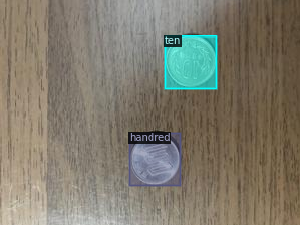

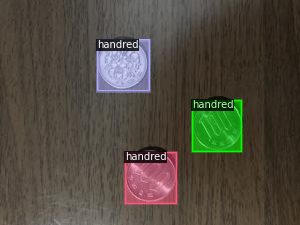

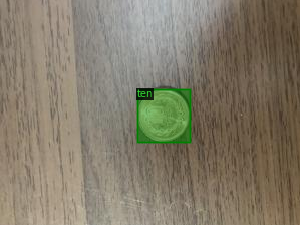

In [ ]:
coins_metadata = MetadataCatalog.get("coins")
dataset_dicts = DatasetCatalog.get("coins")

for d in random.sample(dataset_dicts, 3):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=coins_metadata, scale=1.0)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

# 訓練

Model ZooにあるFaster RCNNを訓練します．今回は４種類の硬貨を検出するので，`cfg.MODEL.ROI_HEADS.NUM_CLASSES=4`にします．




In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("coins",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0004
cfg.SOLVER.MAX_ITER = (
    500
)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/08 12:26:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[02/08 12:26:58 d2.engine.train_loop]: Starting training from iteration 0
[02/08 12:27:03 d2.utils.events]:  eta: 0:01:58  iter: 19  total_loss: 2.431  loss_cls: 1.528  loss_box_reg: 0.9066  loss_rpn_cls: 0.0009485  loss_rpn_loc: 0.005021  time: 0.2473  data_time: 0.0122  lr: 7.9924e-06  max_mem: 2471M
[02/08 12:27:08 d2.utils.events]:  eta: 0:01:53  iter: 39  total_loss: 2.207  loss_cls: 1.365  loss_box_reg: 0.928  loss_rpn_cls: 0.001057  loss_rpn_loc: 0.003959  time: 0.2442  data_time: 0.0051  lr: 1.5984e-05  max_mem: 2471M
[02/08 12:27:13 d2.utils.events]:  eta: 0:01:48  iter: 59  total_loss: 1.916  loss_cls: 0.9985  loss_box_reg: 0.8822  loss_rpn_cls: 0.002765  loss_rpn_loc: 0.004654  time: 0.2446  data_time: 0.0060  lr: 2.3976e-05  max_mem: 2471M
[02/08 12:27:18 d2.utils.events]:  eta: 0:01:43  iter: 79  total_loss: 1.693  loss_cls: 0.7539  loss_box_reg: 0.9189  loss_rpn_cls: 0.001965  loss_rpn_loc: 0.003357  time: 0.2445  data_time: 0.0055  lr: 3.1968e-05  max_mem: 2471M
[02/08 1

訓練したモデルを読み込みます．

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
predictor = DefaultPredictor(cfg)

# テスト

訓練に使っていない画像で硬貨を検出してみます．

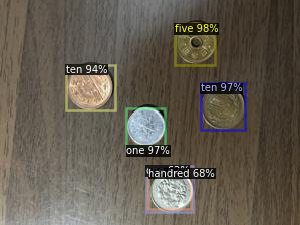

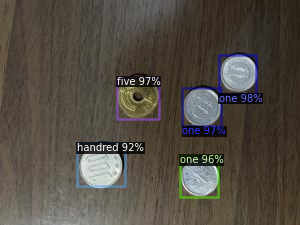

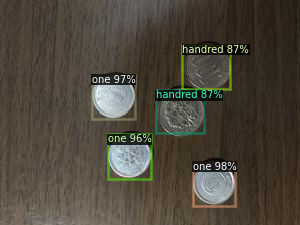

In [ ]:
for num in [4693, 4694, 4695]:    
    im = cv2.imread(f"./coins/IMG_{num}.jpg")
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=coins_metadata, 
                   scale=1.0
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])